# SyncMCMC Tutorial

The following tutorial serves to illustrate proper implementation of SyncMCMC for inferring the flux normalization, self-absorption frequency, and characteristic electron frequency corresponding to synchrotron emission from a relativistic jet. These parameters, when combined with minimal energy equipartition arguments, allow for constraints on the total electron density and bulk Lortentz factor of the jet, as well as the minimum energy and physical source size.

SyncMCMC contains a number of executable scripts which can be utilized for parameter extraction. 

   -`run_analysis.py`: This script allows the user to run the analysis on a single data set or time epoch. Parameter estimates are obtained for four unique models (Spectrum 1, Spectrum 2, weighted spectrum with flux normalization factors equal, and weighted spectrum with unique flux normalization factors (5 free parameters), and the results are output to unique files for each model as specified in the script. The script can also pass a number of arguments such as plotting the MCMC traces or corner plots for diagnostic purposes.
   
   -`run_all_epochs.py`: This script executes the MCMC analysis on a collection of data sets spanning multiple time epochs. It automatically saves the plots corresponding to the best fit parameter estimates, and outputs the data to unique files for each model respetively. Unlike run_analysis.py, this script performs the fits for only three models Spectrum 1, Spectrum 2, and the weighted spectrum with flux normalization factors equal). There is no interactivitiy with this script. Parameter estimates for each model and time epoch are output live in the terminal as the script runs.

For an in-depth description of each model described above, please see the `model.ipynb` file.

Here, we demonstrate proper usage of both run_analysis.py and run_all_epochs.py, and describe proper formatting for data files.

### Data file formatting

Data files must be spcified in the following format. Columns should describe the frequency, flux, and error, in that order, and should be comma-separated. All comment lines must begin with a '#'.

An example data file is given below.

        #FREQ,FLUX,ERROR
        1.8E9,2.29,0.08
        4.9E9,12.17,0.05
        6.7E9,16.75,0.06
        8.6E9,20.76,0.24
        15.4E9,22.06,0.52
        19.1E9,21.89,0.10
        24.4E9,20.65,0.11
        43.6E9,13.63,0.19

In [102]:
from all_classes import FluxFrequencyPriors, UniformPrior,FluxFrequencyPriorsCombinedSpectrum, BoundedGaussianPrior, make_estimate
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import corner
import argparse
import re
from model import *
from read_data_io import load_data
from runmcmc import run_PTmcmc
sns.set_style("white")

### run_analysis.py

This script takes as input the data file corresponding to a particular epoch. The data file must be specified when executing the script and should be titled accordingly (ie. "event_ndays") where ndays refers to the elapsed time since initial detection. The file itself should be formatted appropriately: there should be only three columns listing the frequency, flux, and error in that order. Columns should be only comma separated. Any additional comment lines must begin with a '#'.

       Usage: model.py [options] -i filename
    
       Outputs best fit parameters for F_v, v_a, and v_m and a plot of the fit.

       Options:

       -i     --input     Specify data file
       -r     --raw       Plot raw data
       -fp    --fprior    Speicify lower and upper bounds for prior on flux normalization factor (Default: 1:110)
       -vap   --vaprior   Specify lower and upper bounds for prior on self absorption frequency (Default 1E9:1E12)
       -vam   --vamprior  Specify lower and upper bounds for prior on characteristic frequency (Default 1E9:1E12)
       -lnfp  --lnfprior  Specify lower and upper bounds for prior on fractional amount by which variance is underestimated
       -t     --trace     Plot MCMC traces for F_v, v_a, v_m
       -c     --corner    Plot corner plots
       -Ft     --F_true    Specify guess value for F_v
       -vat   --va_true   Specify guess value for va
       -vmt   --vm_true   Specify guess value for vm 

When running the script, required arguments include the data file name, the the guess values for F, $\nu_a$, and $\nu_m$.


For example, the script can be called via:
    
        python ./run_analysis.py -i Sw1644+57_197days -Ft 36 -vat 1E10 -vmt 1E10 -t
        
where the output will produce a plot of the best fit parameters as well as a time series of the sampler chains (-t argument). 

The argument -r produces a plot of the raw data. 

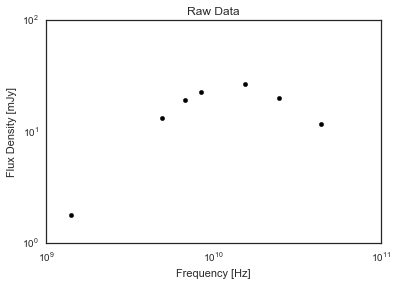

In [68]:
# Load data

flux, freqs, error = load_data('syncmcmc/data/Sw1644+57_197days')

# Plot raw data

plt.scatter(freqs,flux,color='k')
plt.xscale('log')
plt.yscale('log')
plt.title('Raw Data')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Flux Density [mJy]')
plt.show()

The script begins by defining each separate model and their respective likelihood functions. In each case, free parameters include the flux normalization factor F, the self-absorption frequency $\nu_a$, the characteristic frequency $\nu_m$, and the fractional amount by which the variances are underestimated, f. Model 4 includes an additionl parameter -- a second flux normalization factor.

We will also define known parameters here. For a description, please see model.ipynb.

In [41]:
### Define known parameters ### 


p = 2.5 
epsilon_e = 0.1 * (p-2.)/(p-1.)
epsilon_b = 0.1


# Spectral slopes

beta_1 = 2.
beta_2 = 1./3.
beta_3 = (1.-p)/2.
beta5_1 = 5.0/2.0
beta5_2 = (1.0 - p)/2.0



# Shape of spectrum at each break

s_1 = 1.5
s_2 = (1.76 + 0.05*p)
s_3 = (0.8 - 0.03*p)
s_4 = 3.63 * p - 1.60
s_5 = 1.25 - 0.18 * p


Next, uniform priors are defined for each model. In the case of model 4, there are 5 free parameters, and thus, we define a unique set of priors corresponding to that model.

In [42]:
# Define priors

priors = FluxFrequencyPriors(UniformPrior(1.,55.),
          UniformPrior(1E8,1E11),
          UniformPrior(1E8,1E11), 
          UniformPrior(-3,0.01))

# Define priors for model 4

priors_spec4 = FluxFrequencyPriorsCombinedSpectrum(UniformPrior(1.,55.),
          UniformPrior(1.,55.),
          UniformPrior(1E8,1E11),
          UniformPrior(1E8,1E11), 
          UniformPrior(-3,0.01))

The "guess parameters" which are passed as arguments to the script serve to initilaze the location of our walkers.

In [43]:
F_true = 10**1.56
va_true = 10**9.83
vm_true = 10**10.04

# Define number of dimensions and number of walkers

ndim, nwalkers = 4, 100

# Define initial positions of walkers in phase space for models 1, 2, and 3

frand = np.random.normal(loc=F_true,size=nwalkers,scale=0.1)
frand_2 = np.random.normal(loc=F_true,size=nwalkers,scale=0.1)
varand = np.random.normal(loc=va_true,size=nwalkers,scale=1.E3)
vmrand = np.random.normal(loc=vm_true,size=nwalkers,scale=1.E3)
yerrand = np.random.normal(loc=-0.7,size=nwalkers,scale=0.1)

pos = np.column_stack((frand,varand,vmrand,yerrand)) 
pos_add_dim = np.expand_dims(pos,axis=0)
final_pos = np.repeat(pos_add_dim, 5, axis=0)


# Define initial positions for spectrum 4 walkers

pos_spec4 = np.column_stack((frand,frand_2,varand,vmrand,yerrand)) 
pos_add_dim_spec4 = np.expand_dims(pos_spec4,axis=0)
final_pos_spec4 = np.repeat(pos_add_dim_spec4, 5, axis=0)

Given the log likelihoods and our priors, we can now unleash our walkers and sample the posterior, which we do for each model.

In [44]:
# Run MCMC sampler for each model

sampler, sams = run_PTmcmc(5,lnlike, priors, final_pos, ndim, nwalkers, logargs=[freqs,flux,error])

sampler_spec2, sams_spec2 = run_PTmcmc(5,lnlike_spec2, priors, final_pos, ndim, nwalkers, logargs=[freqs,flux,error])

sampler_spec3, sams_spec3 = run_PTmcmc(5,lnlike_spec3, priors, final_pos, ndim, nwalkers, logargs=[freqs,flux,error])

sampler_spec4, sams_spec4 = run_PTmcmc(5,lnlike_spec4, priors_spec4, final_pos_spec4, 5, nwalkers, logargs=[freqs,flux,error])

We can take a look at the time series traces corresponding to a particular model (if we've passed the -t argument when calling the script).

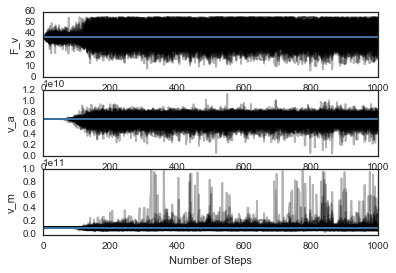

In [45]:
plt.subplot(3,1,1)
plt.plot(sampler.chain[0, :, :, 0].T,color="k", alpha=0.3)
plt.axhline(F_true, color='#4682b4')
plt.ylabel('F_v')
plt.xlabel('Number of Steps')

plt.subplot(3,1,2)
plt.plot(sampler.chain[0,:, :, 1].T, color="k", alpha=0.3)
plt.axhline(va_true, color='#4682b4')
plt.ylabel('v_a')
plt.xlabel('Number of Steps')

plt.subplot(3,1,3)
plt.plot(sampler.chain[0,:, :, 2].T, color="k", alpha=0.3)
plt.axhline(vm_true, color='#4682b4')
plt.ylabel('v_m')
plt.xlabel('Number of Steps')

We find that the values converge, or "burn in" after about 200 steps, so we will go ahead and discard the first 300 steps (we'll play it safe).

In [46]:
# Burn off initial steps
samples = sampler.chain[0,:, 300:, :].reshape((-1, ndim))

samples_spec2 = sampler_spec2.chain[0,:, 300:, :].reshape((-1, ndim))

samples_spec3 = sampler_spec3.chain[0,:, 300:, :].reshape((-1, ndim))

samples_spec4 = sampler_spec4.chain[0,:, 300:, :].reshape((-1, 5))


Similarly, we can take a look at the one and two dimensional projections of our posterior probability distributions. The histograms along the diagonal represent the marginalized distributions for each individual parameter. The other plots illustrate the covariance among the parameters.

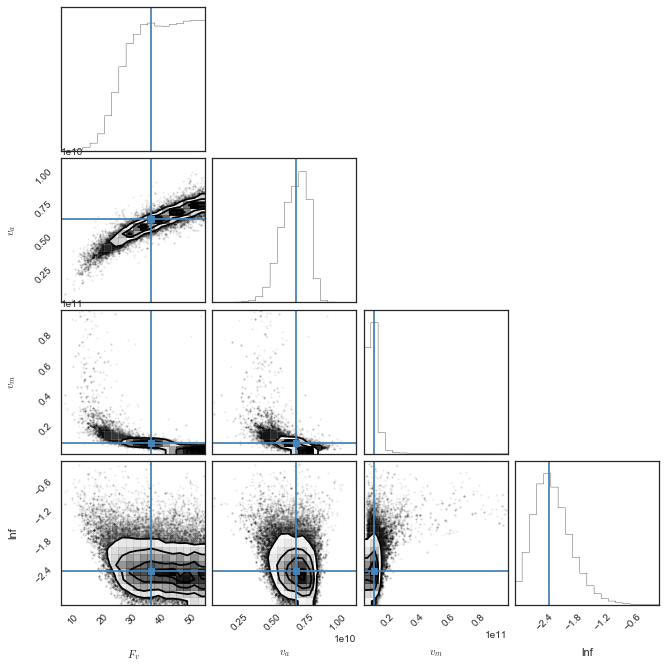

In [47]:
fig = corner.corner(samples, labels=["$F_v$", "$v_a$", "$v_m$", "lnf"],truths=[F_true,va_true,vm_true, np.log(0.1)])

Now that the logistics are squared away, let's get what we came here for. Our parameter estimates. For now, we'll take the values corresponding to the maximum of the posterior. 

In [48]:
F_mcmc, va_mcmc, vm_mcmc,lnf_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],axis=0)))


F_spec2_mcmc, va_spec2_mcmc, vm_spec2_mcmc, lnf_spec2_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples_spec2, [16, 50, 84],axis=0)))

F_spec3_mcmc, va_spec3_mcmc, vm_spec3_mcmc,lnf_spec3_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples_spec3, [16, 50, 84],axis=0)))

F_spec4_mcmc, F2_spec4_mcmc,va_spec4_mcmc, vm_spec4_mcmc,lnf_spec4_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples_spec4, [16, 50, 84],axis=0)))





print("""Model 1 MCMC result:
    F_v_spec1 = {0[0]} +{0[1]} -{0[2]} (truth: {1})
    v_a_spec1 = {2[0]} +{2[1]} -{2[2]} (truth: {3})
    v_m_spec1 = {4[0]} +{4[1]} -{4[2]} (truth: {5})
""".format(F_mcmc, F_true, va_mcmc, va_true, vm_mcmc, vm_true))

print("""Model 2 MCMC result:
    F_v_spec2 = {0[0]} +{0[1]} -{0[2]} (truth: {1})
    v_a_spec2 = {2[0]} +{2[1]} -{2[2]} (truth: {3})
    v_m_spec2 = {4[0]} +{4[1]} -{4[2]} (truth: {5})
""".format(F_spec2_mcmc, F_true, va_spec2_mcmc, va_true, vm_spec2_mcmc, vm_true))

print("""Model 3 MCMC result:
    F_v_spec3 = {0[0]} +{0[1]} -{0[2]} (truth: {1})
    v_a_spec3 = {2[0]} +{2[1]} -{2[2]} (truth: {3})
    v_m_spec3 = {4[0]} +{4[1]} -{4[2]} (truth: {5})
""".format(F_spec3_mcmc, F_true, va_spec3_mcmc, va_true, vm_spec3_mcmc, vm_true))

print("""Model 4 MCMC result:
    F_v_spec4 = {0[0]} +{0[1]} -{0[2]} (truth: {1})
    v_a_spec4 = {2[0]} +{2[1]} -{2[2]} (truth: {3})
    v_m_spec4 = {4[0]} +{4[1]} -{4[2]} (truth: {5})
""".format(F_spec4_mcmc, F_true, va_spec4_mcmc, va_true, vm_spec4_mcmc, vm_true))

Model 1 MCMC result:
    F_v_spec1 = 39.78297353387883 +10.500441201485735 -10.713114092365718 (truth: 36.30780547701014)
    v_a_spec1 = 6780251014.064613 +887406649.1197681 -1138908132.3640394 (truth: 6760829753.919819)
    v_m_spec1 = 9213911674.547686 +3068332371.2676125 -1670480648.6378708 (truth: 10964781961.43183)

Model 2 MCMC result:
    F_v_spec2 = 38.878064651137116 +11.448304090411348 -18.31095201746359 (truth: 36.30780547701014)
    v_a_spec2 = 6042208417.82369 +474478456.41275597 -437753647.7819996 (truth: 6760829753.919819)
    v_m_spec2 = 5367962377.194969 +800347664.974638 -1275697305.9907432 (truth: 10964781961.43183)

Model 3 MCMC result:
    F_v_spec3 = 39.57640298467988 +9.988575241003957 -11.398642866341099 (truth: 36.30780547701014)
    v_a_spec3 = 6357172818.546633 +597136277.5805893 -921602531.9395161 (truth: 6760829753.919819)
    v_m_spec3 = 10192701647.113874 +2810220124.8492374 -1764614935.555975 (truth: 10964781961.43183)

Model 4 MCMC result:
    F_v_spec

Finally, we can plot each of our models with the parameter estimates that we found above. 

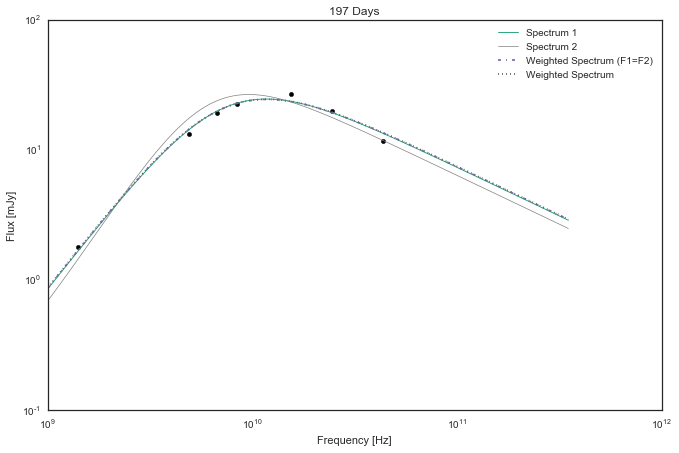

In [49]:
v_range = np.linspace(1E9,350E9,1E4)
plt.figure(figsize=(11,7))
plt.scatter(freqs,flux,color='k')
plt.plot(v_range,spectrum(v_range,F_mcmc[0],va_mcmc[0],vm_mcmc[0]),color='#1b9e77',label='Spectrum 1',lw='0.9')
plt.plot(v_range,spectrum_2(v_range,F_spec2_mcmc[0],va_spec2_mcmc[0],vm_spec2_mcmc[0]),color='grey',label='Spectrum 2',lw='0.7')
plt.plot(v_range,weighted_spectrum(v_range,F_spec3_mcmc[0],va_spec3_mcmc[0],vm_spec3_mcmc[0]),ls='-.',color='#7570b3',label='Weighted Spectrum (F1=F2)')
plt.plot(v_range,comb_spectrum(v_range,F_spec4_mcmc[0],F2_spec4_mcmc[0],va_spec4_mcmc[0],vm_spec4_mcmc[0]),ls=':',color='#666666',label='Weighted Spectrum')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.title('197 Days')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Flux [mJy]')
plt.show()


We can see that Spectrum 2 does a poor job of fitting the parameters. This is indeed consistent with the fact that Spectrum 2 assumes we are in a later epoch (one in which $\nu_m$ < $\nu_a$), when our MCMC parameter estimates have confirmed that we are not. On the other hand, the other three models do a similar job of characterizing the spectrum. The fact that the fits are so consistent suggests that we are still firmly rooted in an epoch in which $\nu_m$ dominates. 

### run_all_epochs.py    

       Usage: run_all_epochs.py [options]

       Outputs best fit parameters for F_v, v_a, and v_m and a plot of the fit.


       Options:
       -fp    --fprior    Speicify lower and upper bounds for prior on flux normalization factor (Default: 1:110)
       -vap   --vaprior   Specify lower and upper bounds for prior on self absorption frequency (Default: 1E9:1E12)
       -vam   --vamprior  Specify lower and upper bounds for prior on characteristic frequency (Default: 1E9:1E12)
       -lnfp  --lnfprior  Specify lower and upper bounds for uncertainty scaling factor (Default: -0.03:-0.01)



This script takes as optional arguments prior bounds for all paramters. Default values are passed if no values are specified. The script can be run simply by passing

    python ./run_all_epochs.py
    
The script does, however, require defining within the it an array containing the path and name of all data files, placed in ascending order since the onset of the relativistic jet. In addition, arrays containing the guess value for each parameter across each epoch should also be included. Once again, the formatting of data files must be as described above in order for the script to run. Sample data sets are included in this repository, and the script is currently structured such that it points to these files. 



These arrays must be defined by the user. They currently point to and describe sample data in the repository. 

In [76]:
# Load data 

data_files = ['syncmcmc/data/Sw1644+57_5days','syncmcmc/data/Sw1644+57_10days','syncmcmc/data/Sw1644+57_15days',
              'syncmcmc/data/Sw1644+57_22days','syncmcmc/data/Sw1644+57_36days','syncmcmc/data/Sw1644+57_51days',
              'syncmcmc/data/Sw1644+57_68days','syncmcmc/data/Sw1644+57_97days','syncmcmc/data/Sw1644+57_126days',
              'syncmcmc/data/Sw1644+57_161days','syncmcmc/data/Sw1644+57_197days','syncmcmc/data/Sw1644+57_216days',
              'syncmcmc/data/Sw1644+57_244days','syncmcmc/data/Sw1644+57_390days','syncmcmc/data/Sw1644+57_457days',
              'syncmcmc/data/Sw1644+57_582days']



# Define guess values for initial iteration, all models

true_flux_values = [30.,9.,10.,9.,13.,16.,25.,33.,38.,33.,36.,43.,98.,52.,44.,40.]
true_va_values = [1E11,1E10,1E10,1E10,1E10,1E10,1E10,1E10,1E10,1E10,1E10,1E10,1E10,1E10,1E10,1E10]
true_vm_values = [1E12,1E11,1E11,1E11,1E11,1E11,1E10,1E10,1E10,1E10,1E10,1E10,1E10,1E9,1E9,1E9]
true_lnf_values = [-0.7,-0.7,-0.7,-0.7,-0.7,-0.7,-0.7,-0.7,-0.7,-0.7,-0.7,-0.7,-0.7,-0.7,-0.7,-0.7]

The priors can be defined as an optional argument when calling the script. If they are not defined, default values will be used.

In [113]:
# Define priors

priors_1 = [UniformPrior(1.,55.),
          UniformPrior(1E8,1E11),
          UniformPrior(1E8,1E11), 
          UniformPrior(-3,0.01)]

va_bounds = '1E9,1E12'
vm_bounds = '1E9,1E12'


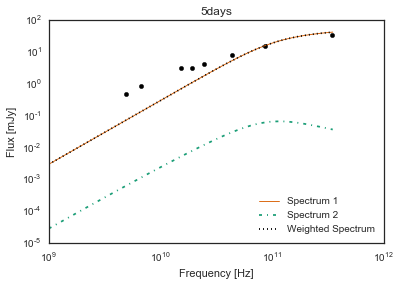

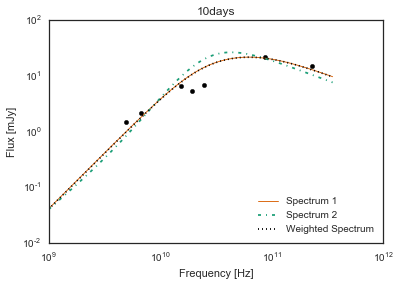

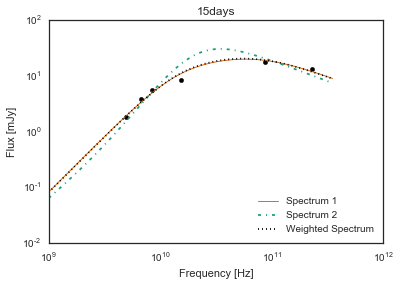

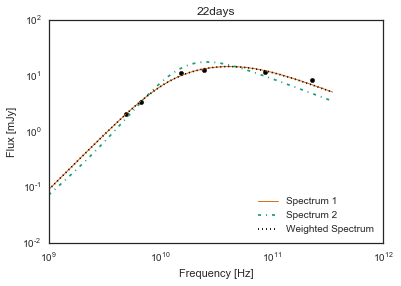

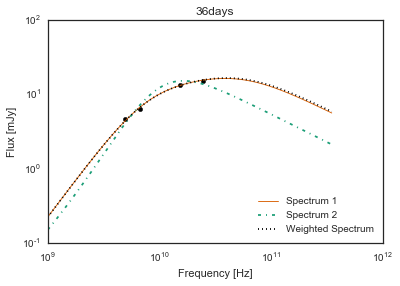

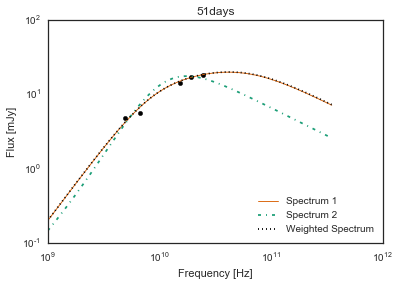

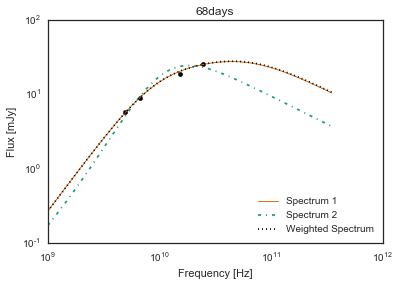

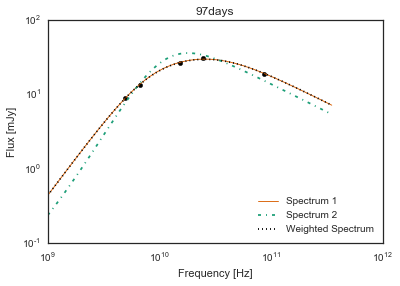

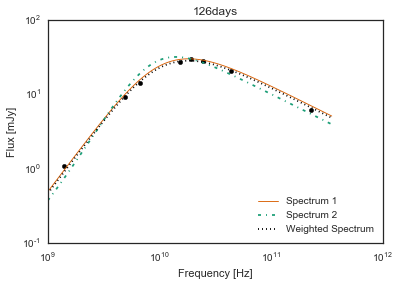

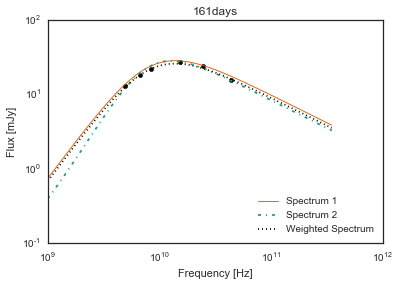

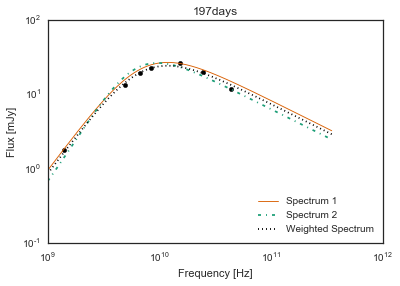

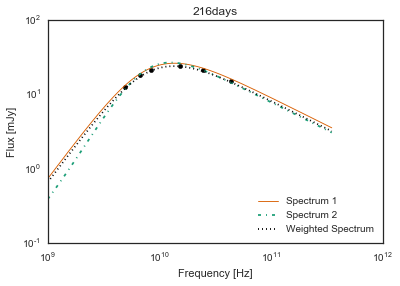

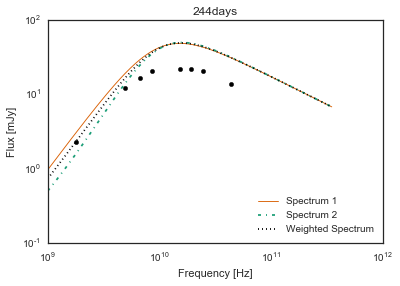

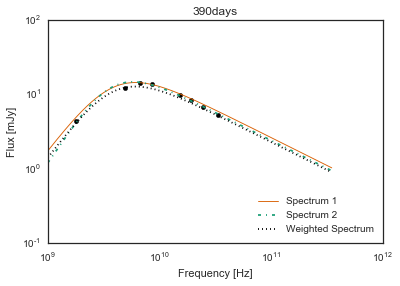

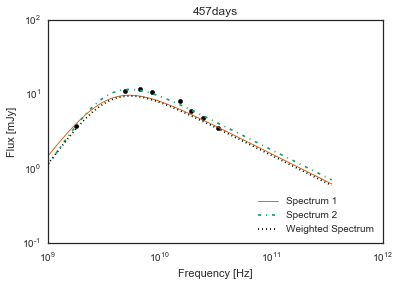

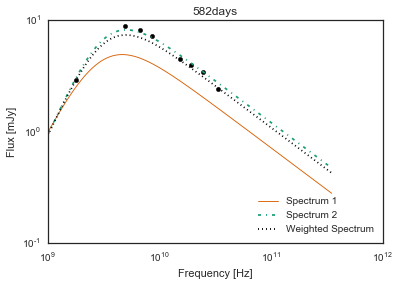

In [114]:

# Create a list of priors, one for each model

priors_list = [priors_1, priors_1, priors_1]

# Create array of likelihood functions corresponding to each model

lnlikes = [lnlike, lnlike_spec2, lnlike_spec3]


# Begin parameter estimation for each data file and model

for (data_file, F_true, va_true, vm_true,lnf_true) in zip(data_files, true_flux_values, true_va_values, true_vm_values,true_lnf_values):

    flux, freqs, error = load_data(data_file) # Parse data
    
    # Combine priors for all parameters into a single array

    priors = [FluxFrequencyPriors(*p) for p in priors_list]
  
  
    # Define number of dimensions, number of walkers, and number of temperatures 
    
    ndim, nwalkers, ntemps = 4, 100, 5
  
  
    # Define initial positions of walkers in phase space for models 1, 2, and 3
    
    frand = np.random.normal(loc=F_true,size=nwalkers,scale=0.1)
    varand = np.random.normal(loc=va_true,size=nwalkers,scale=1.E3)
    vmrand = np.random.normal(loc=vm_true,size=nwalkers,scale=1.E3)
    yerrand = np.random.normal(loc=-0.7,size=nwalkers,scale=0.1)
    
  
    pos = np.column_stack((frand,varand,vmrand,yerrand)) 
    pos_add_dim = np.expand_dims(pos,axis=0)
    final_pos = np.repeat(pos_add_dim, 5, axis=0)
  
  
    all_samples = []
    flux_stdevs = []
    all_model_ests = []

    # Run the MCMC sampler for all three models for a given time epoch

    for (prior, lnlike, mod_name) in zip(priors, lnlikes, range(1,4)):
        
        sampler, sams = run_PTmcmc(ntemps, lnlike, prior, final_pos, ndim, nwalkers,logargs=[freqs,flux,error])


        # Burn off initial steps
        samples = sampler.chain[0,:, 500:, :].reshape((-1, ndim))
        all_samples.append(samples)


        # Calculate parameter estimates and uncertainties
        estimates = [make_estimate(s, g) for (s, g) in zip(samples.T, (F_true,va_true,vm_true,lnf_true))]
        all_file_line = [make_estimate(s, g).get_value() for (s, g) in zip(samples.T, (F_true,va_true,vm_true,lnf_true))]
        all_model_ests.append(all_file_line)
        flux_est, va_est, vm_est, lnf_est = estimates

        # Update priors with results from previous parameter estimation 

    #flux_stdevs.append(estimates[0].estimate_uncertainty())
    priors_list.append([UniformPrior(1,110),
          UniformPrior(float(va_bounds.split(',')[0]), va_est.upper),
          UniformPrior(float(vm_bounds.split(',')[0]), vm_est.upper),
          UniformPrior(-3.,-0.01)])
    
    # Plot fits from all models on a single figure 

    v_range = np.linspace(1E9,350E9,1E4)
    plt.figure()
    plt.scatter(freqs,flux,color='k')
    plt.plot(v_range,spectrum(v_range,all_model_ests[0][0][0],all_model_ests[0][1][0],all_model_ests[0][2][0]),color='#d95f02',label='Spectrum 1',lw='0.9')
    plt.plot(v_range,spectrum_2(v_range,all_model_ests[1][0][0],all_model_ests[1][1][0],all_model_ests[1][2][0]),ls='-.',color='#1b9e77',label='Spectrum 2')
    plt.plot(v_range,weighted_spectrum(v_range,all_model_ests[2][0][0],all_model_ests[2][1][0],all_model_ests[2][2][0]),ls=':',color='k',label='Weighted Spectrum')
    plt.legend(loc='lower right')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Flux [mJy]')
    plt.title(data_file.split('_')[1])
    plt.show()